## Load data

In [1]:
import os
import pandas as pd

def load_data(data_root):
    X = []
    y = []
    for label_folder in os.listdir(data_root):
        folder_path = os.path.join(data_root, label_folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.endswith('.csv'):
                    file_path = os.path.join(folder_path, file)
                    data = pd.read_csv(file_path, header=None).values.T  # shape: (250000, 8)
                    X.append(data)
                    y.append(label_folder)
    return X, y

In [2]:
signals, labels = load_data("MAFAULDA")

print(signals[0])
print(labels[0])

[[-0.83663  -0.70637  -0.6712   ... -0.78113  -0.71353  -0.73931 ]
 [ 1.29     -2.0251    0.61405  ...  1.2151   -0.94528   1.1335  ]
 [ 0.2463   -0.90278   0.33512  ...  0.29521  -0.2445    0.36549 ]
 ...
 [ 0.07708   0.061588  0.066658 ... -0.1976   -0.21477  -0.20356 ]
 [-0.10002  -0.1643   -0.11457  ... -0.16816  -0.25749  -0.18556 ]
 [-0.15698   0.36468  -0.20152  ... -0.034704 -0.030518 -0.10197 ]]
horizontal_misalignment


In [3]:
import numpy as np

for i, data in enumerate(signals):
    if np.isnan(data).any():
        print(f"Missing values detected in sample {i}.")

## Feature Engineering

In [4]:
from scipy.stats import skew, kurtosis

def extract_stat_features(signal):
    return {
        'mean': np.mean(signal),
        'std': np.std(signal),
        'max': np.max(signal),
        'min': np.min(signal),
        'rms': np.sqrt(np.mean(signal**2)),  # root mean square
        'skewness': skew(signal),
        'kurtosis': kurtosis(signal),
        'crest_factor': np.max(np.abs(signal)) / np.sqrt(np.mean(signal**2))
    }

In [5]:
def compute_rotation_frequency(tachometer_signal, fs):
    N = len(tachometer_signal)
    fft_result = np.fft.fft(tachometer_signal)
    fft_magnitude = np.abs(fft_result[:N // 2])
    freqs = np.fft.fftfreq(N, d=1/fs)[:N // 2]
    peak_idx = np.argmax(fft_magnitude)
    fr = freqs[peak_idx]
    return fr

In [28]:
from scipy.signal import stft

def extract_stft_features(signal, fs, fr):
    freqs, _, Zxx = stft(signal, fs=fs, nperseg=4096)
    mag = np.abs(Zxx)
    
    # Find indices of fr, 2fr, and 3fr
    fr_indices = [np.argmin(np.abs(freqs - f)) for f in [fr, 2*fr, 3*fr]]

    # Extract features at fr, 2fr, and 3fr
    features = {}
    for i, idx in enumerate(fr_indices):
        features[f'fr_{i+1}_mean'] = np.mean(mag[idx, :])
    
    return features

In [29]:
all_features = []

for i, data in enumerate(signals):
    label = labels[i]
    combined_features = {}
    
    # Compute rotation frequency (fr) from the tachometer signal
    tachometer_signal = data[0]
    fr = compute_rotation_frequency(tachometer_signal, fs=50000)
    combined_features['fr'] = fr
    
    for channel_idx in range(data.shape[0]):
        signal = data[channel_idx]
        
        # Extract statistical features
        stat_features = extract_stat_features(signal)
        for key, value in stat_features.items():
            combined_features[f'channel_{channel_idx}_{key}'] = value
        
        # Extract STFT features at fr, 2fr, 3fr
        if channel_idx != 0:
            stft_features = extract_stft_features(signal, fs=50000, fr=fr)
            for key, value in stft_features.items():
                if channel_idx != 0:
                    combined_features[f'channel_{channel_idx}_{key}'] = value
    
    combined_features['label'] = label
    all_features.append(combined_features)

features_df = pd.DataFrame(all_features)

print(features_df.head())

     fr  channel_0_mean  channel_0_std  channel_0_max  channel_0_min  \
0  12.0       -0.000348       1.581787         5.0885        -1.1669   
1  12.0        0.001224       1.583230         5.1090        -1.1178   
2  12.0       -0.001437       1.579752         5.0883        -1.1491   
3  12.0        0.002844       1.588314         5.1149        -1.1508   
4  26.6       -0.003788       1.593595         5.0765        -1.2312   

   channel_0_rms  channel_0_skewness  channel_0_kurtosis  \
0       1.581787            2.508516            4.344647   
1       1.583230            2.505950            4.331515   
2       1.579753            2.513654            4.370045   
3       1.588316            2.492287            4.261619   
4       1.593600            2.479826            4.198653   

   channel_0_crest_factor  channel_1_mean  ...  channel_7_max  channel_7_min  \
0                3.216932        0.005574  ...        0.85669       -0.33820   
1                3.226946        0.003652  ...

## Split data to train set and test set

In [30]:
X = features_df.iloc[:, :-2]
y = features_df.iloc[:, -1]

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Data Visualization and Class Balancing

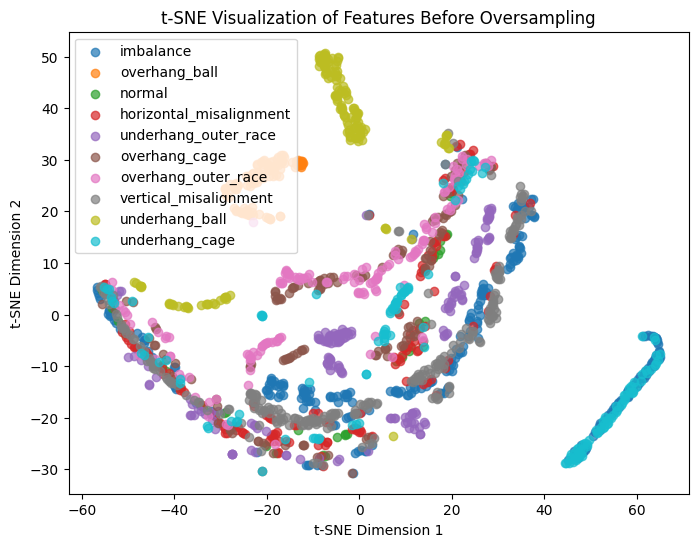

In [32]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_embedded = tsne.fit_transform(X_train)

plt.figure(figsize=(8, 6))
for label in set(y_train):
    idx = y_train == label
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=label, alpha=0.7)

plt.title("t-SNE Visualization of Features Before Oversampling")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.show()

In [33]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [34]:
from collections import Counter

print("Class distribution before oversampling:", Counter(y_train))
print("Class distribution after oversampling:", Counter(y_train_resampled))

Class distribution before oversampling: Counter({'imbalance': 275, 'vertical_misalignment': 241, 'underhang_outer_race': 159, 'underhang_cage': 152, 'horizontal_misalignment': 152, 'overhang_outer_race': 147, 'overhang_cage': 146, 'underhang_ball': 142, 'overhang_ball': 105, 'normal': 41})
Class distribution after oversampling: Counter({'vertical_misalignment': 275, 'normal': 275, 'underhang_cage': 275, 'imbalance': 275, 'underhang_outer_race': 275, 'overhang_cage': 275, 'underhang_ball': 275, 'horizontal_misalignment': 275, 'overhang_outer_race': 275, 'overhang_ball': 275})


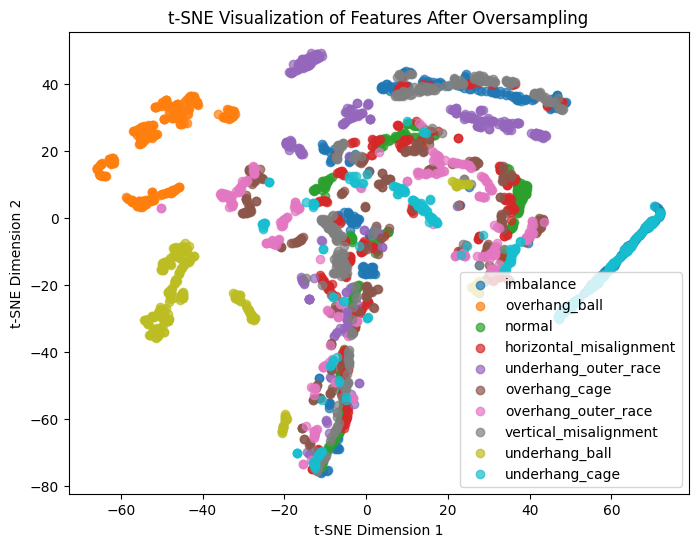

In [35]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_embedded = tsne.fit_transform(X_train_resampled)

plt.figure(figsize=(8, 6))
for label in set(y_train_resampled):
    idx = y_train_resampled == label
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=label, alpha=0.7)

plt.title("t-SNE Visualization of Features After Oversampling")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.show()

## Cross Validation

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from imblearn.pipeline import Pipeline

pipeline = Pipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42))
])

scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

cv_results = cross_validate(pipeline, X, y, cv=5, scoring=scoring)

for metric in scoring:
    print(f"{metric}: {cv_results['test_' + metric].mean():.6f}")

accuracy: 0.918076
precision_macro: 0.925481
recall_macro: 0.911751
f1_macro: 0.910787


## Model Building and Evaluation

In [37]:
from sklearn.metrics import classification_report

clf = RandomForestClassifier()
clf.fit(X_train_resampled, y_train_resampled)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

horizontal_misalignment       0.98      0.98      0.98        45
              imbalance       1.00      0.97      0.98        58
                 normal       1.00      1.00      1.00         8
          overhang_ball       1.00      1.00      1.00        32
          overhang_cage       1.00      1.00      1.00        42
    overhang_outer_race       0.98      0.98      0.98        41
         underhang_ball       1.00      1.00      1.00        44
         underhang_cage       0.97      1.00      0.99        36
   underhang_outer_race       1.00      1.00      1.00        25
  vertical_misalignment       0.98      1.00      0.99        60

               accuracy                           0.99       391
              macro avg       0.99      0.99      0.99       391
           weighted avg       0.99      0.99      0.99       391



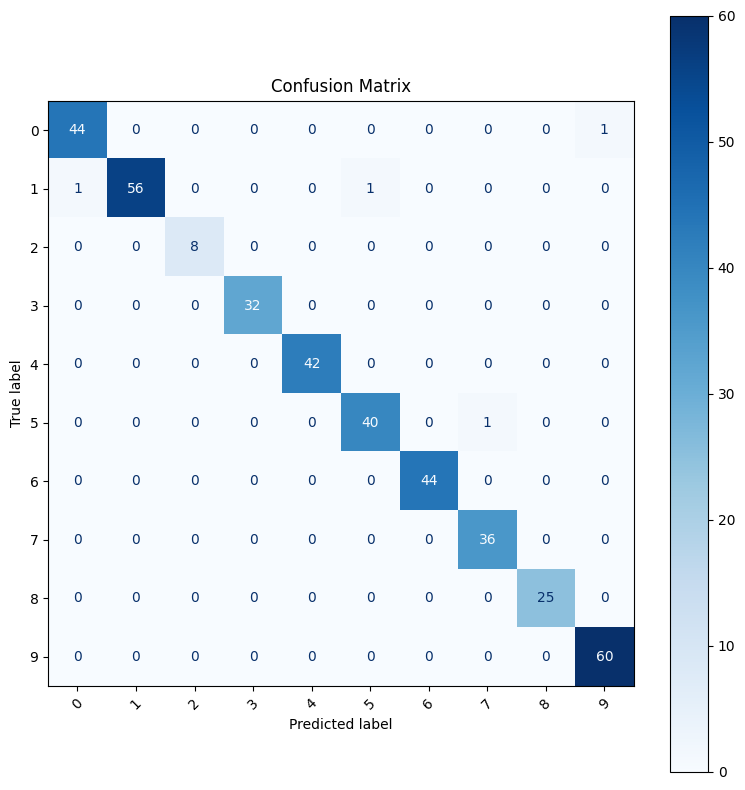

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Auto-detect class labels
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(include_values=True, cmap='Blues', ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

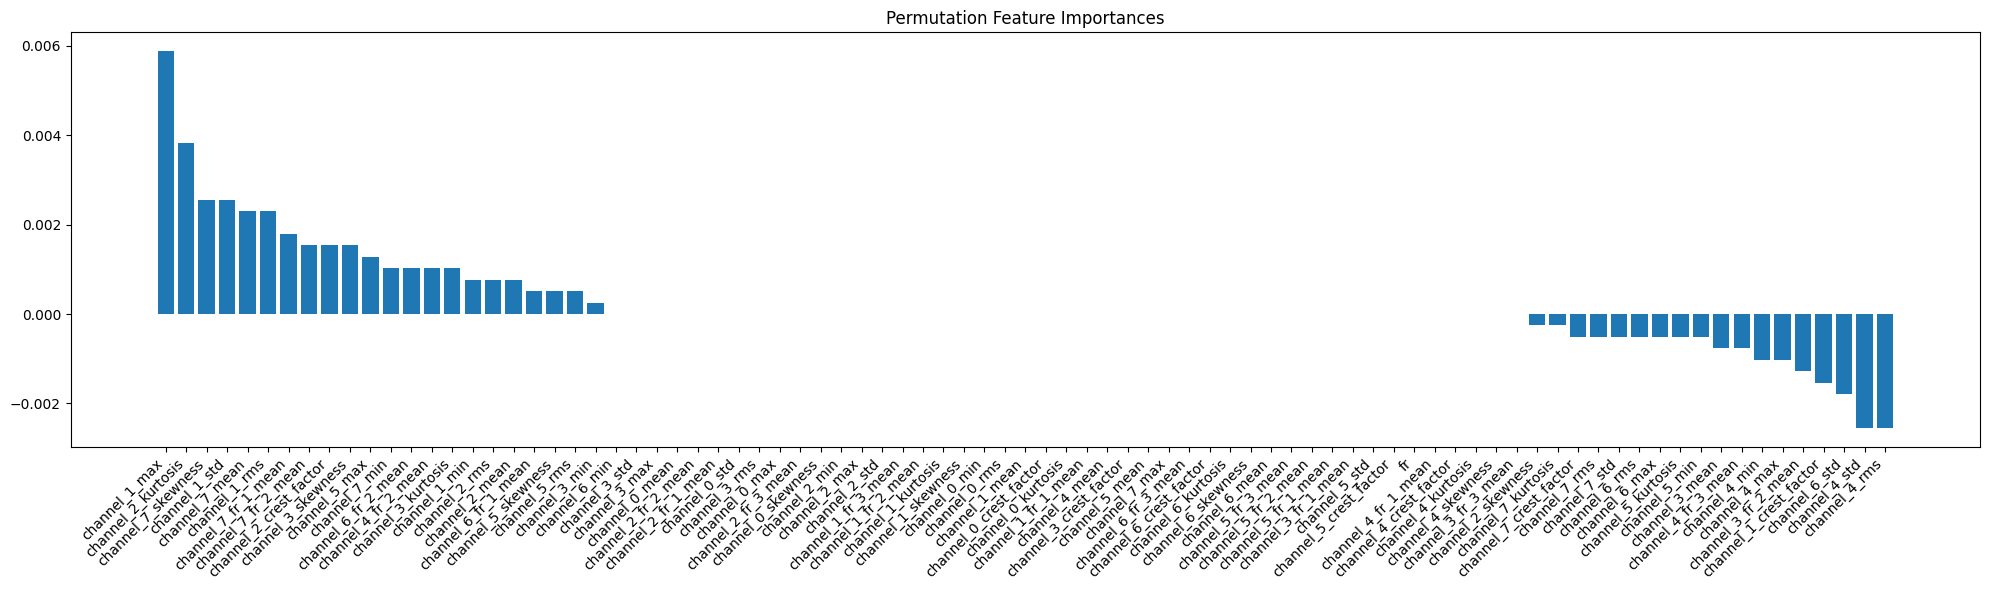

In [40]:
from sklearn.inspection import permutation_importance

# Compute permutation importance on test or validation set
result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Get sorted indices
sorted_idx = result.importances_mean.argsort()[::-1]

# Plot
plt.figure(figsize=(20, 6))
plt.bar(range(X_test.shape[1]), result.importances_mean[sorted_idx])
plt.xticks(range(X_test.shape[1]), np.array(feature_names)[sorted_idx], rotation=45, ha='right')
plt.title("Permutation Feature Importances")
plt.tight_layout()
plt.show()

In [ ]:
# Get the top 22 feature names
top_22_features = np.array(feature_names)[sorted_idx[:22]]

# Filter the dataset to include only the top 22 features
X_train_top22 = X_train[top_22_features]
X_test_top22 = X_test[top_22_features]

In [52]:
print(top_22_features)

['channel_1_max' 'channel_2_kurtosis' 'channel_7_skewness' 'channel_1_std'
 'channel_7_mean' 'channel_1_rms' 'channel_7_fr_1_mean'
 'channel_7_fr_2_mean' 'channel_2_crest_factor' 'channel_3_skewness'
 'channel_5_max' 'channel_7_min' 'channel_6_fr_2_mean'
 'channel_4_fr_2_mean' 'channel_3_kurtosis' 'channel_1_min'
 'channel_2_rms' 'channel_2_mean' 'channel_6_fr_1_mean'
 'channel_5_skewness' 'channel_5_rms' 'channel_3_min']


In [48]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Define the objective function
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 5, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    
    # Create the model with suggested hyperparameters
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    # Train the model
    clf.fit(X_train_top22, y_train)
    
    # Predict on the test set
    y_pred = clf.predict(X_test_top22)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Create a study and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)

# Retrain the model with the best hyperparameters
best_params = study.best_params
clf_optimized = RandomForestClassifier(**best_params, random_state=42)
clf_optimized.fit(X_train_top22, y_train)

# Evaluate the optimized model
y_pred_optimized = clf_optimized.predict(X_test_top22)
print(classification_report(y_test, y_pred_optimized))

[I 2025-05-30 20:20:37,273] A new study created in memory with name: no-name-c6842a82-3094-4eaf-80ee-3c0b219835c9
[I 2025-05-30 20:20:37,862] Trial 0 finished with value: 0.9744245524296675 and parameters: {'n_estimators': 76, 'max_depth': 40, 'min_samples_split': 12, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.9744245524296675.
[I 2025-05-30 20:20:39,094] Trial 1 finished with value: 0.989769820971867 and parameters: {'n_estimators': 157, 'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.989769820971867.
[I 2025-05-30 20:20:40,575] Trial 2 finished with value: 0.989769820971867 and parameters: {'n_estimators': 209, 'max_depth': 21, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.989769820971867.
[I 2025-05-30 20:20:42,426] Trial 3 finished with value: 0.9820971867007673 and parameters: {'n_estimators': 256, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.

Best hyperparameters: {'n_estimators': 200, 'max_depth': 36, 'min_samples_split': 2, 'min_samples_leaf': 1}
                         precision    recall  f1-score   support

horizontal_misalignment       1.00      1.00      1.00        45
              imbalance       1.00      1.00      1.00        58
                 normal       1.00      1.00      1.00         8
          overhang_ball       1.00      1.00      1.00        32
          overhang_cage       1.00      1.00      1.00        42
    overhang_outer_race       1.00      1.00      1.00        41
         underhang_ball       1.00      1.00      1.00        44
         underhang_cage       1.00      1.00      1.00        36
   underhang_outer_race       1.00      1.00      1.00        25
  vertical_misalignment       1.00      1.00      1.00        60

               accuracy                           1.00       391
              macro avg       1.00      1.00      1.00       391
           weighted avg       1.00      1.00 

In [50]:
X_top22 = X[top_22_features]

pipeline = Pipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(**best_params, random_state=42))
])

cv_results = cross_validate(pipeline, X_top22, y, cv=5, scoring=scoring)

for metric in scoring:
    print(f"{metric}: {cv_results['test_' + metric].mean():.6f}")

accuracy: 0.911929
precision_macro: 0.920537
recall_macro: 0.902815
f1_macro: 0.904583


## Export the model

In [51]:
import pickle

with open('fault_type_classifier_rf.pkl', 'wb') as f:
    pickle.dump(clf_optimized, f)

In [ ]:
# with open('random_forest_model.pkl', 'rb') as f:
#     clf_loaded = pickle.load(f)